In [6]:
from transformers import ViltProcessor, ViltForQuestionAnswering
from PIL import Image
import torch
import pandas as pd
import configs_py3 as configs
import matplotlib.pyplot as plt
import os
import skimage.io as io
import json

In [7]:
def load_dataset():
    df = pd.read_csv(configs.dataset_path)
    train_df = df[:configs.NUM_TRAIN]
    val_df = df[configs.NUM_TRAIN:configs.NUM_TRAIN + configs.NUM_VAL]
    test_df = df[configs.NUM_TRAIN + configs.NUM_VAL:configs.NUM_TRAIN + configs.NUM_VAL + configs.NUM_TEST]

    df = df.reset_index()  # make sure indexes pair with number of rows
    train_df = train_df.reset_index()
    val_df = val_df.reset_index()
    test_df = test_df.reset_index()
    
    return df, train_df, val_df, test_df

In [8]:
def get_model_children(model):
    for name, module in model.named_children():
        print(name, '->', module)
    return

In [20]:
def try_threshold(model, processor, val_df, threshold=0.5):
    original_model_outputs = []
    abstaining_model_outputs = []

    for index, row in val_df.iterrows():
        imgId = row['image_id']
        imgFilename = 'COCO_' + configs.dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
        imgPath = configs.imgDir + imgFilename
        
        if not os.path.isfile(imgPath):
            continue
        
        
        if index < 5:
            I = io.imread(imgPath)
            
            plt.imshow(I)
            plt.axis('off')
            plt.show()
            
        image = Image.open(imgPath)
        text = row['random_question']
        
        # prepare inputs
        try:
            inputs = processor(image, text, return_tensors="pt")
        except Exception as e:
            I = io.imread(imgPath)
        
            plt.imshow(I)
            plt.axis('off')
            plt.show()
            print(e, "==> Skipping this image")
            continue                
        # forward pass
        with torch.no_grad():
            outputs = model(**inputs)

        
        
        
        logits = outputs.logits
        idx = logits.argmax(-1).item()
        
        softmax_output = torch.nn.functional.softmax(outputs.logits, dim=1)
        softmax_output = softmax_output[0, idx].item()

        if softmax_output < threshold:
            model_output = "ABSTAIN"
        
        else:
            model_output = model.config.id2label[idx]
        
        abstaining_model_outputs.append(model_output)
        original_model_outputs.append(model.config.id2label[idx])
        
        if index < 5:
            print("Random Question:", text)
            print("Random Question answer before thresholding:", model.config.id2label[idx])
            print("Ramdom Question answer after thresholding:", model_output)
            print("threshold:", threshold)
            print("Confidence:", logits[0, idx].item())
            print("Softmax output: ", softmax_output)
            print("Original Question:", row['original_question'])
            print("Original Question answer:", row['multiple_choice_answer'])
    
    return original_model_outputs, abstaining_model_outputs



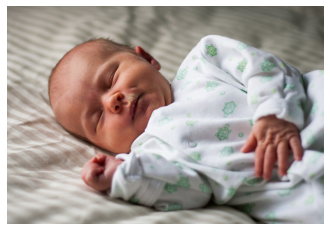

Random Question: What type of animal is hugging the bear?
Random Question answer before thresholding: baby
Ramdom Question answer after thresholding: ABSTAIN
threshold: 0.5
Confidence: -0.4741639494895935
Softmax output:  0.4587932527065277
Original Question: What kind of baby is this?
Original Question answer: human


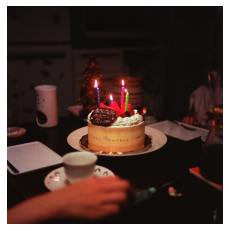

Random Question: Is this indoors or outdoors?
Random Question answer before thresholding: indoors
Ramdom Question answer after thresholding: indoors
threshold: 0.5
Confidence: 3.3536059856414795
Softmax output:  0.9776345491409302
Original Question: What kind of candies are on the cake?
Original Question answer: birthday


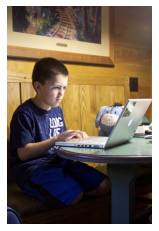

Random Question: What color is the giraffe?
Random Question answer before thresholding: brown
Ramdom Question answer after thresholding: ABSTAIN
threshold: 0.5
Confidence: -0.4521929621696472
Softmax output:  0.3664272725582123
Original Question: What does the boy have in his hand?
Original Question answer: laptop


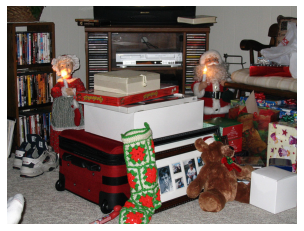

Random Question: What is this dog laying on?
Random Question answer before thresholding: floor
Ramdom Question answer after thresholding: floor
threshold: 0.5
Confidence: 1.5569736957550049
Softmax output:  0.5631441473960876
Original Question: What holiday decorations are visible?
Original Question answer: christmas


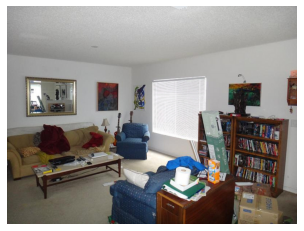

Random Question: What is the paper called under the pizza?
Random Question answer before thresholding: paper
Ramdom Question answer after thresholding: ABSTAIN
threshold: 0.5
Confidence: -0.9031505584716797
Softmax output:  0.3304896950721741
Original Question: What color is dominant?
Original Question answer: white


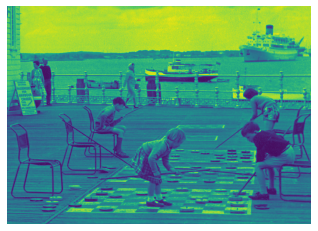

Unsupported number of image dimensions: 2 ==> Skipping this image


In [21]:
# download a model pre-trained on the VQA dataset
model = ViltForQuestionAnswering.from_pretrained(configs.CHECKPOINT)

# use the corresponding preprocessor class (ViltProcessor)
processor = ViltProcessor.from_pretrained(configs.CHECKPOINT)

# load the dataset
df, train_df, val_df, test_df = load_dataset()

original_model_outputs, abstaining_model_outputs = try_threshold(model, processor, val_df, threshold=0.5)

In [ ]:
original_model_outputs, abstaining_model_outputs

(['baby', 'indoors', 'brown', 'floor', 'paper'],
 ['ABSTAIN', 'indoors', 'ABSTAIN', 'floor', 'ABSTAIN'])

In [ ]:
df['original_model_outputs'] = original_model_outputs
df['abstaining_model_outputs'] = abstaining_model_outputs
df.head()

In [ ]:
df.to_csv(configs.dataset_path, index=False)